In [1]:
!git clone https://github.com/DeepLearningVision-2019/Data_sets.git

Cloning into 'Data_sets'...
remote: Enumerating objects: 10014, done.
remote: Counting objects: 100% (10014/10014), done.
remote: Compressing objects: 100% (10011/10011), done.
remote: Total 10014 (delta 2), reused 10010 (delta 2), pack-reused 0
Receiving objects: 100% (10014/10014), 215.68 MiB | 32.53 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10008/10008), done.


In [0]:
!ls Data_sets/Dogs_vs_cats

test_set  training_set


In [3]:
import numpy as np

import matplotlib.pyplot as plt
import cv2

from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

import os

%matplotlib inline
plt.rcParams['axes.grid'] = False

Using TensorFlow backend.


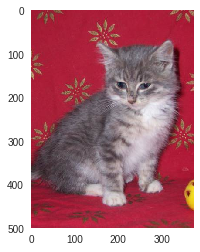

In [0]:
cat_image = cv2.imread('Data_sets/Dogs_vs_cats/training_set/cats/cat.110.jpg')
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)

plt.imshow(cat_image)

In [0]:
# Allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors
train_data_gen = ImageDataGenerator(
rescale=1./255,
validation_split=0.2)

# Standardize the color of each channel
test_data_gen = ImageDataGenerator(rescale=1./255)

# Creates a train data generator and a validation data generator from the train images using a split of 80-20%
# Each image will be 150x150, and the generator will output batches of 20 tensors
train_generator = train_data_gen.flow_from_directory(
'Data_sets/Dogs_vs_cats/training_set/',
target_size=(150, 150),
batch_size=20,
class_mode='binary',
subset='training')

validation_generator = train_data_gen.flow_from_directory(
'Data_sets/Dogs_vs_cats/training_set/',
target_size=(150, 150),
batch_size=20,
class_mode='binary',
subset='validation')

# Image data generator for the test data: it is processed the same as the train data
test_generator = test_data_gen.flow_from_directory(
'Data_sets/Dogs_vs_cats/test_set/',
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu',
                       input_shape=(150,150,3)))
#model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
#model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
#model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36992)             0         
__________

Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator, i.e. after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. The same applies for the validation.

In [0]:
history = model.fit_generator(
train_generator,
epochs=5,
validation_data=validation_generator,
steps_per_epoch=train_generator.samples // 20,
validation_steps=validation_generator.samples // 20)

Epoch 1/5
320/320 [==============================] - 35s 110ms/step - loss: 0.7160 - acc: 0.5917 - val_loss: 0.6022 - val_acc: 0.6687
Epoch 2/5
320/320 [==============================] - 34s 107ms/step - loss: 0.5611 - acc: 0.7186 - val_loss: 0.6182 - val_acc: 0.6644
Epoch 3/5
320/320 [==============================] - 34s 107ms/step - loss: 0.4980 - acc: 0.7717 - val_loss: 0.5206 - val_acc: 0.7500
Epoch 4/5
320/320 [==============================] - 35s 109ms/step - loss: 0.4275 - acc: 0.8098 - val_loss: 0.4897 - val_acc: 0.7469
Epoch 5/5
320/320 [==============================] - 34s 107ms/step - loss: 0.3623 - acc: 0.8445 - val_loss: 0.6461 - val_acc: 0.7412


In [0]:
model.evaluate_generator(test_generator, steps=test_generator.samples // 20)

[0.5994525061547756, 0.7670000010728836]

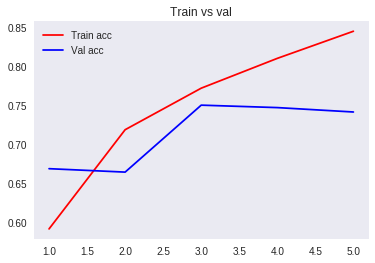

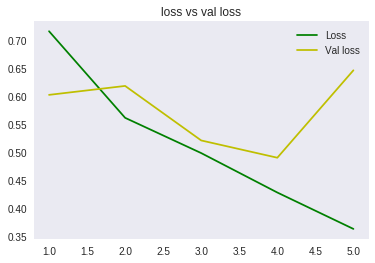

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Train acc')
plt.plot(epochs, val_acc, 'b', label='Val acc')
plt.title('Train vs val')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Loss')
plt.plot(epochs, val_loss, 'y', label='Val loss')
plt.title('loss vs val loss')
plt.legend()
plt.show()


## Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to
train a model able to generalize to new data. Given infinite data, our model would be
exposed to every possible aspect of the data distribution at hand: we would never overfit.
Data augmentation takes the approach of generating more training data from existing
training samples, by "augmenting" the samples via a number of random transformations
that yield believable-looking images. The goal is that at training time, our model would
never see the exact same picture twice. This helps the model get exposed to more aspects
of the data and generalize better.

In [0]:
augmented_data_gen = ImageDataGenerator(
rescale=1./255,
rotation_range = 40,
width_shift_range = 0.2,
height_shift_range = 0.2,
shear_range = 0.2,
zoom_range=0.2,
horizontal_flip=True,
validation_split=0.2,
fill_mode='nearest')

The options we used for the generator are the following:

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate
pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height)
within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half of the images horizontally—relevant
when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after
a rotation or a width/height shift.

(1, 150, 150, 3)


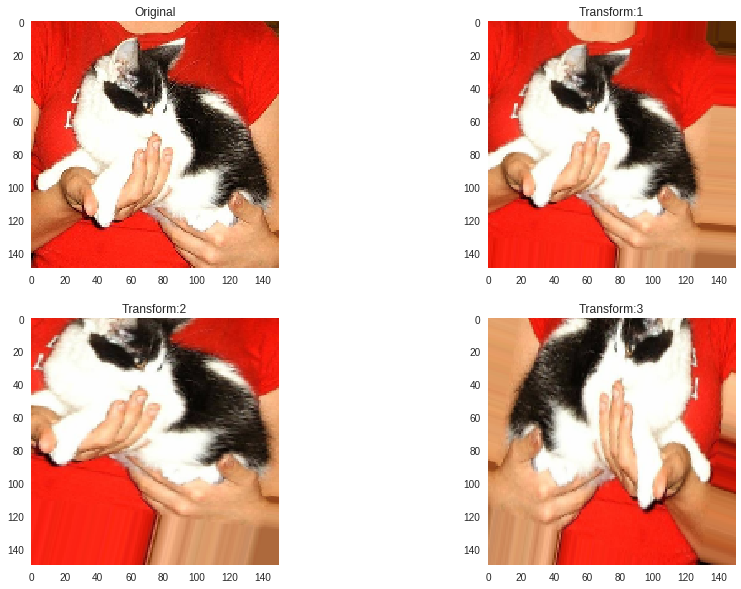

In [5]:
train_cats_dir = 'Data_sets/Dogs_vs_cats/training_set/cats'

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]
# Read the image and resize it
cat_image = cv2.imread(img_path)
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)
cat_image = cv2.resize(cat_image, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.title("Original")
plt.imshow(cat_image)

cat_tensor = np.expand_dims(cat_image, axis=0)
print(cat_tensor.shape)

idx = 1
for batch in augmented_data_gen.flow(cat_tensor, batch_size=1):
  plt.subplot(2, 2, idx + 1)
  plt.title("Transform:" + str(idx))
  plt.imshow(batch[0])
  idx += 1
  if idx % 4 == 0:
    break
plt.show()

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
#model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [9]:
train_generator = augmented_data_gen.flow_from_directory(
'Data_sets/Dogs_vs_cats/training_set/',
target_size=(150, 150),
batch_size=20,
class_mode='binary',
subset='training')

validation_generator = augmented_data_gen.flow_from_directory(
'Data_sets/Dogs_vs_cats/training_set/',
target_size=(150, 150),
batch_size=20,
class_mode='binary',
subset='validation')

test_data_gen = ImageDataGenerator(rescale=1./255)

# Image data generator for the test data: it is processed the same as the train data
test_generator = test_data_gen.flow_from_directory(
'Data_sets/Dogs_vs_cats/test_set/',
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [17]:
history = model.fit_generator(
train_generator,
epochs=100,
validation_data=validation_generator,
steps_per_epoch=train_generator.samples // 20,
validation_steps=validation_generator.samples // 20)

Epoch 1/100
320/320 [==============================] - 80s 249ms/step - loss: 0.6838 - acc: 0.5400 - val_loss: 0.6639 - val_acc: 0.5800
Epoch 2/100
320/320 [==============================] - 78s 244ms/step - loss: 0.6579 - acc: 0.6063 - val_loss: 0.6315 - val_acc: 0.6375
Epoch 3/100
320/320 [==============================] - 77s 241ms/step - loss: 0.6345 - acc: 0.6366 - val_loss: 0.6090 - val_acc: 0.6644
Epoch 4/100
320/320 [==============================] - 76s 236ms/step - loss: 0.6088 - acc: 0.6675 - val_loss: 0.5981 - val_acc: 0.6838
Epoch 5/100
320/320 [==============================] - 75s 233ms/step - loss: 0.5979 - acc: 0.6761 - val_loss: 0.5943 - val_acc: 0.6788
Epoch 6/100
320/320 [==============================] - 74s 230ms/step - loss: 0.5828 - acc: 0.6844 - val_loss: 0.5792 - val_acc: 0.6806
Epoch 7/100
320/320 [==============================] - 75s 233ms/step - loss: 0.5666 - acc: 0.7083 - val_loss: 0.5747 - val_acc: 0.6919
Epoch 8/100
320/320 [===========================

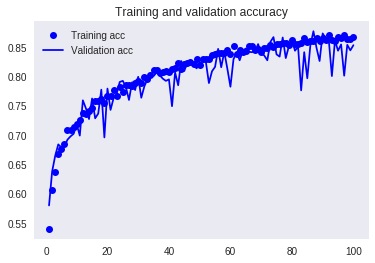

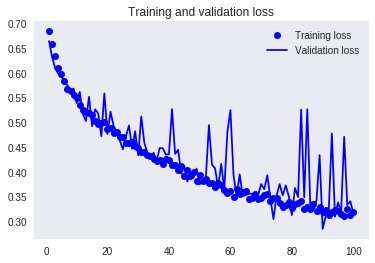

In [18]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 

plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()